# Tokenize full book

In [268]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [269]:
#path = "/home/ubuntu/Downloads/twiker-experiments/datasets/shake/full.txt"
path = "/home/ubuntu/Downloads/twiker-experiments/configs/gpt2/potter/data_files/full.txt"

with open(path, 'r') as fs:
    book_text = fs.read()

In [270]:
import numpy as np

book_tokens = np.array(tokenizer.tokenize(book_text))
book_ids = np.array(tokenizer.convert_tokens_to_ids(book_tokens))

In [271]:
# unique
book_ids_unique, index, counts = np.unique(book_ids, return_index=True, return_counts=True)
book_tokens_unique = book_tokens[index]

print("Total", len(book_ids))
print("Unique", len(book_ids_unique))

Total 1616565
Unique 20542


# For linguistic analysis, we need to add these properties to `book_ids_unique`:

* Counts of appearance: already found above
* Class as one of follows: noun, verb, adjective, ..., punctuation, affix, letter, num, other

In [272]:
def find_non_ascii_characters(input_string):
    non_ascii_characters = [char for char in input_string if ord(char) > 127]
    return np.unique(non_ascii_characters)

# Example usage
non_ascii_characters = find_non_ascii_characters(book_text)
print("Non-ASCII characters:", non_ascii_characters)

Non-ASCII characters: ['£' '¦' '«' '°' '»' 'é' 'ü' '˜' '–' '—' '‘' '’' '“' '”' '•' '…']


In [273]:
import string
import spacy, nltk
from nltk.corpus import words

# punctuation
def is_punctuation(char):
    return char in string.punctuation or char in non_ascii_characters

# pos of word
nlp = spacy.load("en_core_web_sm")
def get_pos(word):
    doc = nlp(word)
    for token in doc:
        return token.pos_

# common word
nltk.download('words')
common_words = set(words.words())
def common_word(word):
    return word.lower() in common_words

[nltk_data] Downloading package words to /home/ubuntu/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [274]:
# 不是G打头 -- 一定是affix
# 是G打头： 1） 单词；2）preffix

classes = []

for tok in book_tokens_unique:
    if len(tok) == 1:
        if is_punctuation(tok):
            classes.append("punctuation")
        elif tok.isalpha():
            classes.append("letter")
        elif tok.isdigit():
            classes.append("num")
        else:
            classes.append("other")
        continue
    
    if tok[0] != "Ġ":
        classes.append("affix")
        continue

    tok = tok[1:]
    if len(tok) == 1:
        if is_punctuation(tok):
            classes.append("punctuation")
            continue
        if tok.isalpha() and tok not in ["I", "a", "A"]:  # here we check single-char words
            classes.append("letter")
            continue
        elif tok.isdigit():
            classes.append("num")
            continue
    if not common_word(tok):
        classes.append("affix")
        continue
    classes.append(get_pos(tok).lower())
classes = np.array(classes)

In [275]:
# let's take a look
classes_unique = np.unique(classes)

for cls in classes_unique:
    print(cls, len(np.where(classes == cls)[0]))
    print(book_tokens_unique[classes == cls][:100])
    print()

adj 1270
['Ġpro' 'Ġother' 'Ġnew' 'Ġmany' 'Ġsuch' 'Ġown' 'Ġgood' 'Ġlast' 'ĠNew'
 'Ġsame' 'Ġhigh' 'ĠPro' 'Ġgreat' 'Ġreal' 'Ġpublic' 'Ġfew' 'Ġdifferent'
 'Ġbig' 'Ġbest' 'Ġlittle' 'Ġtri' 'Ġfull' 'Ġtop' 'Ġmain' 'Ġsmall'
 'Ġcurrent' 'Ġold' 'Ġfree' 'Ġable' 'Ġleast' 'Ġlarge' 'Ġimportant' 'Ġclear'
 'Ġlight' 'Ġmajor' 'Ġavailable' 'Ġcertain' 'Ġpossible' 'Ġproper' 'Ġshort'
 'Ġseveral' 'Ġcomplete' 'Ġyoung' 'Ġlow' 'Ġant' 'Ġstrong' 'Ġsocial'
 'Ġparticular' 'Ġlocal' 'Ġpolitical' 'Ġformer' 'Ġkey' 'Ġspecial' 'Ġblack'
 'Ġsingle' 'Ġquick' 'Ġtrue' 'Ġbad' 'Ġsimilar' 'Ġentire' 'Ġspecific'
 'Ġprevious' 'Ġwhole' 'Ġcommon' 'Ġdue' 'Ġnational' 'Ġrecent' 'Ġgeneral'
 'ĠRed' 'Ġmass' 'ĠNational' 'Ġthird' 'Ġsignificant' 'Ġdifficult' 'Ġhigher'
 'Ġfinal' 'ĠSouth' 'Ġeasy' 'Ġpersonal' 'ĠBlack' 'ĠWhite' 'Ġdead' 'Ġwrong'
 'Ġoriginal' 'Ġprim' 'Ġsoft' 'Ġserious' 'Ġlegal' 'Ġill' 'Ġaverage'
 'Ġperfect' 'Ġsimple' 'Ġprivate' 'Ġworth' 'Ġselect' 'Ġpopular' 'Ġvarious'
 'Ġprofess' 'Ġhot' 'Ġcivil']

adp 103
['Ġof' 'Ġin' 'Ġon' 'Ġfor' '

In [276]:
# this looks reasonable, but classes are too many
# so we select the most meaningful ones
super_classes = ["adj", "adp", "adv", "aux", "verb", "cconj", "noun", "pron", "sconj", "verb"]

# show some stats
class_counts_unique = []
class_counts_total = []

for cls in super_classes:
    idx = np.where(classes == cls)[0]
    class_counts_unique.append(len(idx))
    class_counts_total.append(counts[idx].sum())

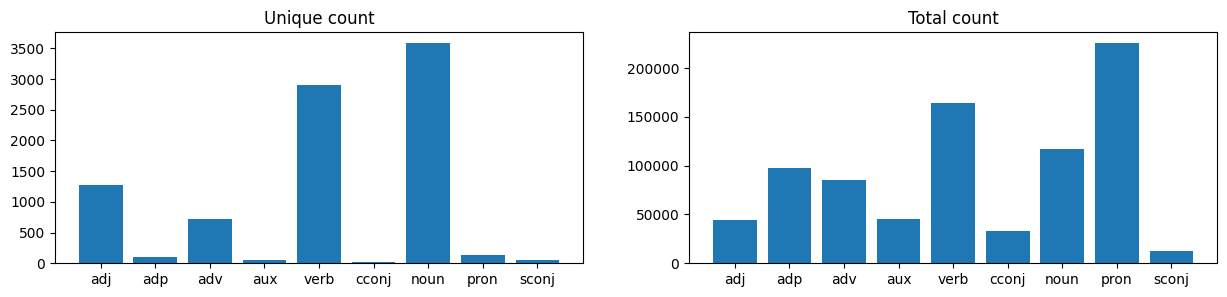

In [277]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].bar(super_classes, class_counts_unique)
ax[0].set_title("Unique count")
ax[1].bar(super_classes, class_counts_total)
ax[1].set_title("Total count")
plt.show()

# Summary

In [278]:
# use `book_ids_unique` to retrieve kernels from trained model
print(len(book_ids_unique), book_ids_unique)

# use `book_tokens_unique` to see word
print(len(book_tokens_unique), book_tokens_unique)

# use `counts` to filter out low-frequency tokens
print(len(counts), counts)

# use `classes` to find the type of words
print(len(classes), classes)

20542 [    0     1     6 ... 50244 50248 50255]
20542 ['!' '"' "'" ... 'Ġdesolate' 'âĢ¦."' 'Ġgazed']
20542 [6337   21 3104 ...    1    2   66]
20542 ['punctuation' 'punctuation' 'punctuation' ... 'verb' 'affix' 'affix']


# Analysis

In [245]:
import torch
from transformers import GPT2LMHeadModel

In [279]:
# Specify the path to the checkpoint file
checkpoint_path = '/home/ubuntu/Downloads/twiker-experiments/results/gpt2/potter/t3vt0.4ttsnbt7e-3'

# Load the model with the checkpoint
model = GPT2LMHeadModel.from_pretrained(checkpoint_path)

# weight
embedding_weights = model.transformer.twiker_model.embedding.weight.detach()
embedding_weights = embedding_weights.reshape(-1, 2, 3)
embedding_weights = torch.softmax(embedding_weights / 0.4, dim=-1)

# extract for book
embedding_weights = embedding_weights[book_ids_unique]
print(embedding_weights.shape)

# extract for value
# if the key  
#wv = embedding_weights[:, 0, :]
#if the value 
wv = embedding_weights[:, 1, :]
print(wv.shape)

torch.Size([20542, 2, 3])
torch.Size([20542, 3])


In [280]:
wv_mean = wv.mean(dim=0)
print(wv_mean)

tensor([0.0017, 0.9960, 0.0023])


In [281]:
# compute distance
dist010 = torch.norm(wv - torch.tensor([0, 1.,0]), dim=1)

# Filter by counts

In [282]:
filter = counts >= 5

book_ids_counts = book_ids_unique[filter]
book_tokens_counts = book_tokens_unique[filter]
classes_counts = classes[filter]
dist010_counts = dist010[filter]

print(len(dist010_counts))

10853


In [283]:
# statistics on all

argsort = torch.argsort(dist010_counts, descending=True)
book_tokens_counts[argsort[:100]]

array(['Ġenchanted', 'Ġalready', 'Ġslightly', 'Ġquite', 'ered', 'Ġhighly',
       'Ġhidden', 'Ġnasty', 'Professor', 'Ġloud', 'Ġmarble', 'Ġsmall',
       'Ġextremely', 'ey', 'Ġancient', 'Ġenormous', 'Ġlarge', 'Ġfamiliar',
       'Ġstill', 'Ġcarefully', 'Ġsuddenly', 'Ġgloomy', 'Ġfeet',
       'Ġstomach', 'Ġsharply', 'Ġvery', 'Ġhuge', 'Ġsat', 'Ġcompletely',
       'Ġdull', 'ĠEnt', 'Ġheavily', "'t", 'Ġstrangely', 'Ġwalking',
       'Ġslowly', 'Ġnearly', 'Ġinvisible', 'Ġjust', 'Ġshould',
       'Ġhorrible', 'Ġpale', 'Ġheavy', 'Ġthoroughly', 'ĠIn', 'Ġceiling',
       'âĢ', 'Ġgreat', 'Ġumb', 'Ġall', 'Ġlittle', 'Ġwith', 'Ġfourth',
       'Ġhastily', 'Ġold', 'Ġstrange', 'Ġtoo', 'Ġsudden', 'Ġunpleasant',
       'Ġblack', 'Ġ', 'Ġhigh', 'ly', 'ĠEaster', 'ĠGeorge', 'Ġgasped',
       'Ġon', 'looking', 'Ġonly', 'Ġtall', 'ta', 'Ġmany', 'ĠâĢ', ',',
       'Ġgre', 'Ġbut', 'Ŀ', 'Ġtalking', 'ĠUm', 'Ġclearly', 'Ġbe', 'Ġand',
       've', 'Ġcould', 'Ġtheir', 'ivering', 'Ġa', '.', 'Ġtail', 'Ġsilver',
       

# Filter by Class

In [284]:
# statistics on role

cls_mean = []
for cls in super_classes:
    filter = (classes_counts == cls)
    book_ids_cls = book_ids_counts[filter]
    book_tokens_cls = book_tokens_counts[filter]
    dist010_cls = dist010_counts[filter]
    mean = dist010_cls.mean()
    cls_mean.append(mean)

<BarContainer object of 10 artists>

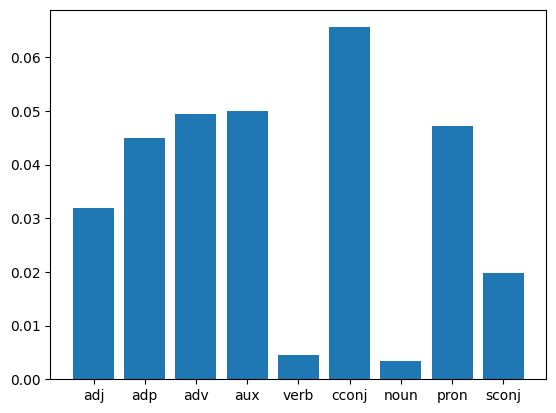

In [285]:
plt.bar(super_classes, cls_mean)